In [39]:
# XODR_FILE='/dataset/opendrive/singlelaneroad.xodr'
XODR_FILE='/dataset/opendrive/borregasave.xodr'

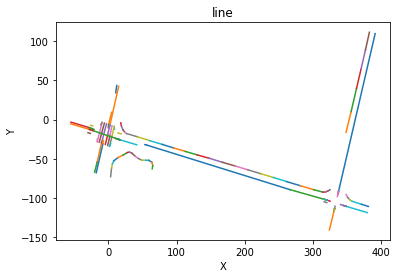

In [45]:
from matplotlib import pyplot as plt
from lxml import etree

import numpy as np
import abc
import math


class GeometryBase:
    def __init__(self, s: float, x: float, y: float, hdg: float, length: float)-> None:
        self.s = float(s)
        self.x = float(x)
        self.y = float(y)
        self.hdg = float(hdg)
        self.length = float(length)
    
    @abc.abstractmethod
    def get_points(self):
        pass


class Line(GeometryBase):
    def __init__(self, s: float, x: float, y: float, hdg: float, length: float)-> None:
        super().__init__(s, x, y, hdg, length)
    
    def get_points(self):
        nx = self.x + self.length * math.cos(self.hdg)
        ny = self.y + self.length * math.sin(self.hdg)
        return (self.x, nx), (self.y, ny) 


class CubicEq:
    def __init__(self, a, b, c, d):
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def cal_cubic(self, p: float) -> float:
        return self.a + self.b*p + self.c*pow(p, 2) + self.d*pow(p, 3)


class ParamPoly3(GeometryBase):
    def __init__(self, s, x, y, hdg, length,
                 aU, bU, cU, dU, aV, bV, cV, dV)-> None:
        super().__init__(s, x, y, hdg, length)
        self.u_eq = CubicEq(float(aU), float(bU), float(cU), float(dU))
        self.v_eq = CubicEq(float(aV), float(bV), float(cV), float(dV))
    
    def get_points(self):
        interval = 1e-2
        now_length = 0.0
        p = 0.0

        xs = [self.u_eq.cal_cubic(p)]
        ys = [self.v_eq.cal_cubic(p)]
        while True:
            prev_p = (self.u_eq.cal_cubic(p), self.v_eq.cal_cubic(p))
            p += interval
            next_p = (self.u_eq.cal_cubic(p), self.v_eq.cal_cubic(p))
            now_length += math.hypot(next_p[0] - prev_p[0], next_p[1], prev_p[1])
            
            if now_length > self.length:
                break
            xs.append(next_p[0]), ys.append(next_p[1])

        return xs, ys


class Curve:
    def __init__(self, x0: float, y0: float, hdg: float):
        self.trans = np.array((x0, y0))
        self.hdg = hdg
        self.R = np.array(((np.cos(hdg), -np.sin(hdg)),
                           (np.sin(hdg),  np.cos(hdg))))
    
    def rel_to_abs(self, p):
        """
        Convert relative coordinate to absolute coord
        (use rotation matrix)
        """
        return self.R.dot(np.array(p)) + self.trans 


class CubicEq:
    def __init__(self, a, b, c, d):
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def cal_cubic(self, p: float) -> float:
        return self.a + self.b*p + self.c*pow(p, 2) + self.d*pow(p, 3)


class ParamCubic:
    def __init__(self, length: float, 
                 au: float, bu: float, cu: float, du: float,
                 av: float, bv: float, cv: float, dv: float):
        self.u_eq = CubicEq(au, bu, cu, du)
        self.v_eq = CubicEq(av, bv, cv, dv)
        self.length = length
    
    def get_points(self):
        interval = 1
        now_length = 0.0
        p = 0.0

        xs = [self.u_eq.cal_cubic(p)]
        ys = [self.v_eq.cal_cubic(p)]
        while True:
            prev_p = (self.u_eq.cal_cubic(p), self.v_eq.cal_cubic(p))
            p += interval
            next_p = (self.u_eq.cal_cubic(p), self.v_eq.cal_cubic(p))
            now_length += math.hypot(next_p[0] - prev_p[0], next_p[1], prev_p[1])
            
            if now_length > self.length:
                break
            xs.append(next_p[0]), ys.append(next_p[1])

        return xs, ys


class OpendriveParser(object):
    def __init__(self, file_dir):
        self.xml_root = self._read_xodr(file_dir)
        self.geometry = []

    def _read_xodr(self, file_dir):
        with open(file_dir, 'r') as f:
            return etree.parse(f).getroot()

    def parse(self):
        for child in self.xml_root:
            if child.tag == 'road':
                self._planeview(child)
    
    def _planeview(self, root):
        for child in root:
            if child.tag == 'planView':
                self._geometry(child)
    
    def _geometry(self, root):
        for child in root:
            if child.tag == 'geometry':
                if self._is_cubic(child):
                    U, V = self._get_paramPoly3(child)
                    g = ParamPoly3(child.get('s'), child.get('x'), child.get('y'), child.get('hdg'), child.get('length'),
                                   U[0], U[1], U[2], U[3], V[0], V[1], V[2], V[3])
                    self.geometry.append(g)
                else:
                    g = Line(child.get('s'), child.get('x'), child.get('y'), child.get('hdg'), child.get('length'))
                    self.geometry.append(g)

    def _is_cubic(self, root) -> bool:
        for child in root:
            if child.tag == 'paramPoly3':
                return True
            else:
                return False

    def _get_paramPoly3(self, root):
        for child in root:
            if child.tag =='paramPoly3':
                U = [child.get('aU'), child.get('bU'), child.get('cU'), child.get('dU')]
                V = [child.get('aV'), child.get('bV'), child.get('cV'), child.get('dV')]
                return U, V


def draw_line(line, plt):
    p1, p2 = line.get_points()
    plt.plot(p1, p2, linestyle='-', marker='')


def draw_param_poly(cubic, plt):
    xs, ys = cubic.get_points()

    c = Curve(cubic.x, cubic.y, cubic.hdg)
    x_li, y_li = [], []
    for p in zip(xs, ys):
        xi, yi = c.rel_to_abs(p)
        x_li.append(xi), y_li.append(yi)

    plt.plot(x_li, y_li, 'ro')


parser = OpendriveParser(XODR_FILE)
parser.parse()

for g in parser.geometry:
    if isinstance(g, Line):
        draw_line(g, plt)
    # elif isinstance(g, ParamPoly3):
    #     draw_param_poly(g, plt)
    # else:
    #     print('except geometry type')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('line')
plt.show()
